In [6]:
# === importing dependencies ===#
import numpy as np
import xarray as xr
import pandas as pd
import os
import sys
import ast
import yaml

import matplotlib.pyplot as plt

from pytorch_tabnet.tab_model import TabNetRegressor
import pickle
from pickle import dump, load
import joblib

import torch

from sklearn.utils import shuffle
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing

#For reproducibility of the results, the following seeds should be selected 
from numpy.random import seed
randSeed = np.random.randint(1000)

root_dir = '/media/harish/SSD/DL_based_wind_profile_estimation'
sys.path.append(root_dir)
from libraries import *
from plotters import *

# === gather variables provided as input arguments ===
config_file = 'config_ERA5_to_obs.yaml'

# === load yaml file and extract variables ===
with open(config_file, 'r') as yaml_file:
    config = yaml.safe_load(yaml_file)
input_file = config['input_file']
input_times_freq = config['input_times_freq']
Coeff_file = config['Coeff_file']
input_variables = config['input_variables']
train_locations = config['train_locations']
train_dates_range = config['train_dates_range']
test_dates_range = config['test_dates_range']
test_locations = config['test_locations']
nEns = config['nEns']
tabnet_param_file = config['tabnet_param_file']
target_variables = config['target_variables']

experiment = config['experiment']

In [2]:
def data_processing_Heligoland(input_file,Coeff_file,input_times_freq,input_variables,target_variables, dates_range, locations,val_arg=None,profiles_file=None,threshold=1):
    '''
    This function reads the nc files and converts them into numpy arrays in the required shape.
    input_file: input variables file (either ERA5 or CERRA)
    ChSh_Coeff_file: target variables file (Chebyshev coefficients file)
    input_time_freq: time frequency of the input variables, since the CERRA and ERA5 are not at the same time frequencey
    input_variables: names of the input variables
    target_variables: target Chebyshev coefficients 
    dates_range: range of the dates to read, can be training or testing
    locations: location indices of the data, out of 11
    var_arg: whether the function should return validation data also along with training, or only training, or testing
    '''
    inputs = xr.open_dataset(input_file)
    coeff = xr.open_dataset(Coeff_file)

    if val_arg:
        #=== Extracting training and validation indices ===# 
        time_coord = coeff.sel(time=slice(*dates_range)).coords['time']

        years = time_coord.dt.year
        months = time_coord.dt.month
        validation_times = np.zeros(len(time_coord), dtype=bool)
        for year in np.unique(years):
            for month in range(1, 13):
                # check if you have enough data in the month
                month_indices = np.where((years == year) & (months == month))[0]
                if len(month_indices) >= int(6*24/input_times_freq):
                    start_index = np.random.choice(len(month_indices) - int(6*24/input_times_freq) - 1)
                    validation_indices = month_indices[start_index:start_index + int(6*24/input_times_freq)]
                    validation_times[validation_indices] = True
                else:
                    # Skip the month if not enough data is available
                    continue
        
        #=== Finish Extracting training and validation indices ===#
        X_train = np.empty((0, len(input_variables)))
        Y_train = np.empty((0, len(target_variables)))
        X_valid = np.empty((0, len(input_variables)))
        Y_valid = np.empty((0, len(target_variables)))

        for loc in locations:
            # --- training ---#
            X_loc = inputs[input_variables].sel(time=time_coord).sel(time=~validation_times,location=loc).to_array().values.T
            Y_loc = coeff.sel(time=time_coord).sel(time=~validation_times,coeff=target_variables).to_array().values[0,...]
            X_train = np.concatenate((X_train, X_loc), axis=0)
            Y_train = np.concatenate((Y_train, Y_loc), axis=0)

            # --- vlaidation ---#
            X_loc = inputs[input_variables].sel(time=time_coord).sel(time=validation_times,location=loc).to_array().values.T
            Y_loc = coeff.sel(time=time_coord).sel(time=validation_times,coeff=target_variables).to_array().values[0,...]
            X_valid = np.concatenate((X_valid, X_loc), axis=0)
            Y_valid = np.concatenate((Y_valid, Y_loc), axis=0)
            
        return X_train, Y_train, X_valid, Y_valid
    else:
        time_coord = coeff.sel(time=slice(*dates_range)).coords['time']

        X = np.empty((0, len(input_variables)))
        Y = np.empty((0, len(target_variables)))

        for loc in locations:
            # --- testing ---#
            X_loc = inputs[input_variables].sel(time=time_coord).sel(location=loc).to_array().values.T
            X = np.concatenate((X, X_loc), axis=0)
            Y_loc = coeff.sel(time=time_coord).sel(coeff=target_variables).to_array().values[0,...]
            Y = np.concatenate((Y, Y_loc), axis=0)

        # Replace NaN values with zeros
        X = np.nan_to_num(X)
        Y = np.nan_to_num(Y)

        return X, Y

In [3]:
coeff = xr.open_dataset(Coeff_file)
ERA5 = xr.open_dataset(input_file)
CERRA = xr.open_dataset(f'{root_dir}/data/CERRA.nc')

In [4]:
X_train,Y_train,X_valid,Y_valid = data_processing_Heligoland(input_file,Coeff_file,input_times_freq,input_variables,target_variables,train_dates_range,train_locations,val_arg=True)
X_test,Y_test = data_processing_Heligoland(input_file,Coeff_file,input_times_freq,input_variables,target_variables,test_dates_range,train_locations)
print('Training inputs shape:',X_train.shape,'training targets shape:',Y_train.shape)
print('Validation inputs shape:',X_valid.shape,'validation targets shape:',Y_valid.shape)
print('Testing inputs shape:',X_test.shape,'testing targets shape:',Y_test.shape)

Training inputs shape: (4620, 24) training targets shape: (4620, 5)
Validation inputs shape: (1440, 24) validation targets shape: (1440, 5)
Testing inputs shape: (955, 24) testing targets shape: (955, 5)


In [ ]:
text_locs = [[0.6, 0.95],[0.6, 0.95],[0.6, 0.95],[0.05, 0.95],[0.05, 0.95],[0.6, 0.95]]
df_Obs = pd.read_csv(f'{root_dir}/data/Heligoland_wind.csv',index_col=0,parse_dates=True)
print(df_Obs.head())
# Resampling the data to hourly frequency, by averaging the values
#df_Obs = df_Obs.resample('H').mean() #['Obs_wind_speed']['ws_50_m']

                     ws_40_m  ws_50_m  ws_60_m  ws_70_m  ws_80_m  ws_90_m  \
2017-03-23 12:10:00     8.67     9.19     9.68    10.19    10.63    10.93   
2017-03-23 12:20:00     8.21     8.77     9.24     9.67    10.13    10.45   
2017-03-23 12:30:00     7.59     8.05     8.63     9.11     9.58    10.03   
2017-03-23 12:40:00     7.71     7.96     8.34     8.83     9.43    10.01   
2017-03-23 12:50:00     7.94     8.55     9.22     9.82    10.35    10.78   

                     ws_100_m  ws_120_m  ws_140_m  ws_160_m  ...  ws_260_m  \
2017-03-23 12:10:00     11.11     10.99     10.60     10.22  ...     10.26   
2017-03-23 12:20:00     10.69     10.92     10.91     10.72  ...     10.76   
2017-03-23 12:30:00     10.41     10.73     10.69     10.64  ...     11.28   
2017-03-23 12:40:00     10.53     11.06     11.10     11.06  ...     11.36   
2017-03-23 12:50:00     11.15     11.64     11.67     11.66  ...     11.45   

                     ws_280_m  ws_300_m  ws_320_m  ws_340_m  ws_360_

In [10]:
run = 0
Ens = 0
OUTPUT_DIR = f'{root_dir}/WES/trained_models/{experiment}/run_{run}/Ens_{Ens}'
# Load model
fSTR = f'{OUTPUT_DIR}//TabNet_HOLDOUT_Ens_{str(Ens)}.pkl'
with open(fSTR, "rb") as f:
    tabReg = pickle.load(f)
tabReg.

TabNetRegressor(n_d=8, n_a=8, n_steps=3, gamma=1.4, cat_idxs=[], cat_dims=[], cat_emb_dim=[], n_independent=1, n_shared=1, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=685, clip_value=1, verbose=1, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=None, scheduler_params={}, mask_type='sparsemax', input_dim=24, output_dim=5, device_name='auto', n_shared_decoder=1, n_indep_decoder=1, grouped_features=[])

In [12]:
obs_levels = np.array([40, 50, 60, 70, 80, 90, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400, 450, 500])
CERRA_levels = np.array([10., 15., 30., 50., 75., 100., 150., 200., 250., 300., 400., 500.])
ERA5_levels = [10, 100]

run = 0
def profle_plotter(fig,gs,X,Y_CERRA,Y_obs=None,date=None,title=None,xlabel=None,ylabel=None):
    axs = fig.add_subplot(gs)
    
    # plot ERA5 10m and 100m wind speeds
    ERA5_ws = X[0,0:2]
    axs.plot(ERA5_ws, ERA5_levels, 'dg', markerfacecolor='g', label='ERA5')

    # Calculate cerra profile
    M_CERRA = WindProfile(Z, Y_CERRA[0,:])
    axs.plot(M_CERRA, Z, '--r', linewidth=2, markerfacecolor='r', label='CERRA')

    # calculate the observed profile
    M_obs = WindProfile(Z, Y_obs[0,:])
    axs.plot(M_obs, Z, '-k', linewidth=2, markerfacecolor='r', label='Obs')
    
    # Initialize arrays to store ensemble predictions
    ensemble_predictions = np.zeros((10, len(Z)))

    for j, Ens in enumerate(np.arange(10)):
        OUTPUT_DIR = f'{root_dir}/WES/trained_models/{experiment}/run_{run}/Ens_{Ens}'

        # Load normalizer
        min_max_scaler = joblib.load(f'{OUTPUT_DIR}/min_max_scaler.joblib')

        # Load model
        fSTR = f'{OUTPUT_DIR}/TabNet_HOLDOUT_Ens_{str(Ens)}.pkl'
        with open(fSTR, "rb") as f:
            tabReg = pickle.load(f)
            Y_pred = min_max_scaler.inverse_transform(tabReg.predict(X_test))
        Mp = WindProfile(Z, Y_pred[0, :])
        # Store ensemble predictions
        ensemble_predictions[j, :] = Mp

    # Calculate percentiles
    median_profile = np.median(ensemble_predictions, axis=0)
    p25_profile = np.percentile(ensemble_predictions, 25, axis=0)
    p75_profile = np.percentile(ensemble_predictions, 75, axis=0)
    #p5_profile = np.percentile(ensemble_predictions, 10, axis=0)
    #p95_profile = np.percentile(ensemble_predictions, 90, axis=0)

    # Plot median
    axs.plot(median_profile, Z, linestyle='-', linewidth=2, label='Ensemble (p50)')

    # Plot shaded regions
    axs.fill_betweenx(Z, p25_profile, p75_profile, color='gray', alpha=0.5, label='Ensemble (p25-p75)')
    #axs.fill_betweenx(Z, p5_profile, p95_profile, color='gray', alpha=0.3, label='Ensemble (p10-p90)')

    axs.set_xlim([0, 30])
    axs.set_ylim([0, 500])

    if title is not None:
        axs.set_title(title)

    if xlabel is not None:
        axs.set_xlabel(xlabel)
    if not xlabel:
        axs.xaxis.set_ticks([])
    
    if ylabel is not None:
        axs.set_ylabel(ylabel)
    if not ylabel:
        axs.yaxis.set_ticks([])
    
    return axs

In [13]:
# profle: best fit date, worst fit date
profile_dates = {'High shear': ['2018-04-05T14:00:00','2018-04-05T13:00:00'],
                'Low shear/well mixed':['2018-02-21T17:00:00','2018-02-22T17:00:00'],
                'LLJ': ['2018-04-09T07:00:00','2018-04-10T07:00:00'],
                'Logarithmic': ['2018-03-13T20:00:00','2018-02-01T17:00:00'],
                }
profile_dates = {'High shear': ['2018-04-05T13:00:00'],
                'Low shear/well mixed':['2018-02-21T17:00:00'],
                'LLJ': ['2018-04-09T07:00:00'],
                'Logarithmic': ['2018-02-01T17:00:00'],
                }
text_locs = [[0.05, 0.95],[0.05, 0.95],[0.05, 0.95],[0.05, 0.95],[0.05, 0.95],[0.6, 0.95]]

0 High shear 2018-04-05T13:00:00


ValueError: x and y must have same first dimension, but have shapes (1, 5) and (24,)

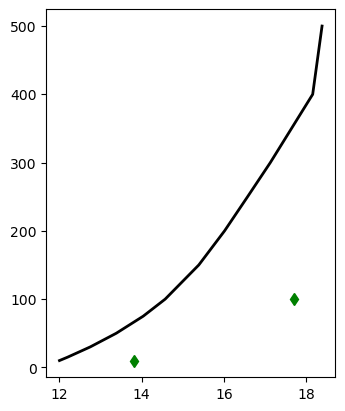

In [15]:
# best profiles
fig = plt.figure(figsize=(12, 4), constrained_layout=True)
gs = fig.add_gridspec(1,4)
xlim = [[0, 30],[0,30],[0,30],[0,30]]
for i in range(1):
    for k,profile in enumerate(profile_dates):
        print(i,profile, profile_dates[profile][i])

        X_test,Y_obs, Y_CERRA = data_processing_Heligoland(input_file,Coeff_file,input_times_freq,input_variables,target_variables,
                                        [profile_dates[profile][i],profile_dates[profile][i]],test_locations,CERRA_coeff_file=f'{root_dir}/data/Chebyshev_Coefficnents.nc')

        title = profile if i == 0 else None
        xlabel = f'Wind Speed (m/s)' #if i == 4 else None
        ylabel = f'Training: ERA5\n Height (m)' if k == 0 else None
        axs = profle_plotter(fig,gs[i,k],X_test,Y_CERRA,Obs=Y_obs,title=title,xlabel=xlabel,ylabel=ylabel)

# Extract legend from one of the subplots
handles, labels = axs.get_legend_handles_labels()
# Create a common legend below the figures
fig.legend(handles, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5, -0.15),fontsize=14)

#plt.savefig(f'{FIG_DIR}/profiles.pdf',dpi=300,bbox_inches='tight')

0 High shear 2017-06-06T10:00:00
0 Low shear/well mixed 2017-11-20T13:00:00
0 LLJ 2017-03-30T02:00:00
0 High wind 2018-01-05T04:00:00


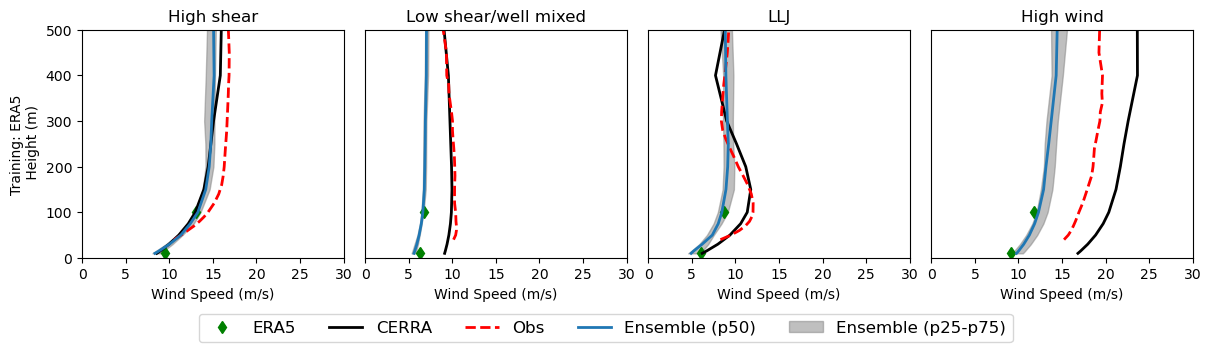

In [ ]:
fig = plt.figure(figsize=(12, 3), constrained_layout=True)
gs = fig.add_gridspec(1,4)
i = 0
for k,profile in enumerate(profile_dates):
    print(i,profile, profile_dates[profile][1])

    X_test,Y_test = data_processing_Heligoland(input_file,Coeff_file,input_variables,target_variables,
                                    [profile_dates[profile][1],profile_dates[profile][1]],test_locations)
    X_test,Y_test = data_processing(input_file,f'{root_dir}/data/Chebyshev_Coefficnents.nc',input_times_freq,input_variables,target_variables,
                                        [profile_dates[profile][1],profile_dates[profile][1]],test_locations)
    Obs = df_Obs[profile_dates[profile][1]:profile_dates[profile][1]].values.T

    title = profile #if i == 0 else None
    xlabel = f'Wind Speed (m/s)' #if i == 4 else None
    ylabel = f'Training: ERA5\n Height (m)' if k == 0 else None
    axs = profle_plotter(fig,gs[i,k],X_test,Y_test,Obs=Obs,title=title,xlabel=xlabel,ylabel=ylabel)

# Extract legend from one of the subplots
handles, labels = axs.get_legend_handles_labels()
# Create a common legend below the figures
fig.legend(handles, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5, -0.15),fontsize=12)

plt.savefig(f'Figures/Tabnet_multi_output_worst_wind_profiles_ERA5_inputs.pdf',dpi=300,bbox_inches='tight',pad_inches=0)